# Bayesian fits

This is a notebook showing a visualization of a Byesian interpretation for the line fit.
The idea is that we generate all possible line fits and reject them if they are not compatible with the data.
Naturally, this is not how most fits are done, but it illustrates the logic behind the Bayes Theorem when applied for fitting lines.


In [1]:
from typing import Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


We start by generating some fake dataset, which is simple enough that we can visualize the results easily. For this reason, the dataset will contain only two  variables.

The simulated example data will be $f(x) = 0.5 x + 0.3 + \epsilon$, where $\epsilon \sim \mathcal{N}(\mu=0, \sigma=0.5)$.


In [2]:
true_alpha = 0.3
true_beta = 0.5
true_eps = 0.5
def generate_data(N: int) -> np.ndarray:
    x = 2*np.random.randn(N, 1)
    epsilon = true_eps*np.random.randn(N, 1)
    z = true_beta*x + true_alpha + epsilon
    return np.concatenate((x, z), axis=1).astype(np.float32)

data = generate_data(N=100)

Given some parameters $\alpha$ and $\beta$, we don't know the true $f(x)$, but we assume it is something like $f(x) = \beta x + \alpha$.

In [3]:
def f(x: np.ndarray, alpha: float, beta: float) -> np.ndarray:
    return beta*x + alpha

Let's plot it for reference:

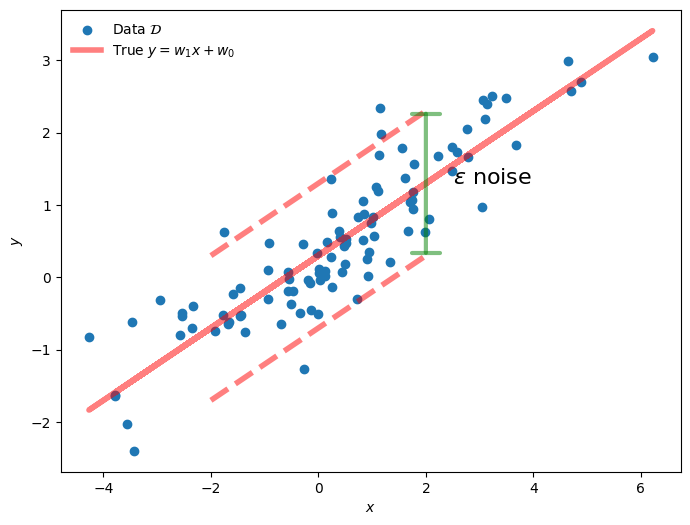

In [4]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(data[:,0], data[:,1], label=r"Data $\mathcal{D}$")
plt.plot(data[:,0], f(data[:,0], true_alpha, true_beta), c='r', ls='-', alpha=0.5, lw=4, label=r"True $y=w_1 x + w_0$")
xs = np.linspace(-2, 2, 10)
plt.plot(xs, f(xs, true_alpha, true_beta) - 2*true_eps, c='r', ls='--', alpha=0.5, lw=4)
plt.plot(xs, f(xs, true_alpha, true_beta) + 2*true_eps, c='r', ls='--', alpha=0.5, lw=4)
xa = 2
ya = f(xa, true_alpha, true_beta)
plt.annotate(xy=(xa, ya + 2*true_eps), xytext=(xa, ya - 2*true_eps), arrowprops=dict(arrowstyle='|-|', lw=3, alpha=0.5, color="green"), text=r"")
plt.text(xa+0.5, ya, s=r"$\epsilon$ noise", size=16)
plt.legend(frameon=False)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.savefig("data.png")

Let's show several random lines and reject the ones that do not agree with the likelihood.

Note that we are producing lines to show in the plots below randomly by taking samples for the posterior and therefore they would differ every time the notebook is executed, but they should still be likely samples that match the data generated above.

In [5]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [6]:
def get_log_prior(A, B):
    #return 0.25*A/A/1/5
    return -0.5*A**2/1**2 - 0.5*B**2/1**2 #- (2*np.pi*p_width**2)
def sample_prior() -> Tuple[float, float]:
    #return (2*np.random.rand() - 1)*1, (2*np.random.rand() - 1)*5
    return 1*np.random.randn(), 1*np.random.randn()
def get_log_likelihood(x, y, A, B, sigma):
    error = f(x, A, B) - y
    return np.sum(-0.5*error**2/sigma**2, axis=0) # - (2*np.pi*sigma**2)
def plot(I: int):
    # how many lines to show in last column
    K = 20
    # assumed noise std. dev.
    sigma=0.5
    # region of alpha and beta to plot
    R = 4
    # take a subset of data points
    D = data[:I,:]
    # make plot
    fig = plt.figure(figsize=(4*5, 4))
    gs = matplotlib.gridspec.GridSpec(1, 7)

    # create alpha and beta grid
    Ax = np.linspace(-R, R, 50)
    Bx = np.linspace(-R, R, 50)
    A, B = np.meshgrid(Ax, Bx)

    # calculate the log prior
    log_prior = get_log_prior(A, B)
    # calculate the log likelihood
    log_likelihood = get_log_likelihood(D[:, 0, np.newaxis, np.newaxis],
                                        D[:, 1, np.newaxis, np.newaxis],
                                        A[np.newaxis, ...],
                                        B[np.newaxis, ...],
                                        sigma=sigma)
    # the log posterior is, except for a constant factor, just the sum of those
    log_posterior = log_prior + log_likelihood

    gsp = matplotlib.gridspec.GridSpecFromSubplotSpec(2, 2, width_ratios=[3,1], height_ratios=[3,1], subplot_spec=gs[0,0], wspace=0, hspace=0)
    ax = plt.subplot(gsp[0,0])
    axy = plt.subplot(gsp[0,1], sharey=ax)
    axx = plt.subplot(gsp[1,0], sharex=ax)
    axy.plot(np.exp(log_prior).sum(axis=1), Ax)
    axx.plot(Bx, np.exp(log_prior).sum(axis=0))
    axx.set(xlabel=r"$w_1$")
    axx.get_xaxis().set_major_locator(matplotlib.ticker.MultipleLocator(2))
    ax.get_yaxis().set_major_locator(matplotlib.ticker.MultipleLocator(2))
    ax.set(title=r"$p(w_0, w_1)$", ylabel=r"$w_0$")
    ax.get_xaxis().set_visible(False)
    axy.get_yaxis().set_visible(False)
    axy.get_xaxis().set_visible(False)
    axx.get_yaxis().set_visible(False)
    m=ax.imshow(np.exp(log_prior), extent=(-R, R, -R, R), aspect="auto", origin='lower')
    #plt.colorbar(m,ax=ax, orientation="horizontal")

    gsp = matplotlib.gridspec.GridSpecFromSubplotSpec(2, 2, width_ratios=[3,1], height_ratios=[3,1], subplot_spec=gs[0,1], wspace=0, hspace=0)
    ax = plt.subplot(gsp[0,0])
    axy = plt.subplot(gsp[0,1], sharey=ax)
    axx = plt.subplot(gsp[1,0], sharex=ax)
    axy.plot(np.exp(log_likelihood).sum(axis=1), Ax)
    axx.plot(Bx, np.exp(log_likelihood).sum(axis=0))
    axx.set(xlabel=r"$w_1$")
    axx.get_xaxis().set_major_locator(matplotlib.ticker.MultipleLocator(2))
    ax.get_yaxis().set_major_locator(matplotlib.ticker.MultipleLocator(2))
    ax.set(title=r"$p(\mathcal{D}|w_0,w_1)$", ylabel=r"$w_0$")
    ax.get_xaxis().set_visible(False)
    axy.get_yaxis().set_visible(False)
    axy.get_xaxis().set_visible(False)
    axx.get_yaxis().set_visible(False)
    m=ax.imshow(np.exp(log_likelihood), extent=(-R, R, -R, R), aspect="auto", origin='lower')
    #plt.colorbar(m,ax=ax, orientation="horizontal")

    gsp = matplotlib.gridspec.GridSpecFromSubplotSpec(2, 2, width_ratios=[3,1], height_ratios=[3,1], subplot_spec=gs[0,2], wspace=0, hspace=0)
    ax = plt.subplot(gsp[0,0])
    axy = plt.subplot(gsp[0,1], sharey=ax)
    axx = plt.subplot(gsp[1,0], sharex=ax)
    axy.plot(np.exp(log_posterior).sum(axis=1), Ax)
    axx.plot(Bx, np.exp(log_posterior).sum(axis=0))
    axx.set(xlabel=r"$w_1$")
    axx.get_xaxis().set_major_locator(matplotlib.ticker.MultipleLocator(2))
    ax.get_yaxis().set_major_locator(matplotlib.ticker.MultipleLocator(2))
    ax.set(title=r"$p(w_1, w_0|\mathcal{D})$", ylabel=r"$w_0$")
    ax.get_xaxis().set_visible(False)
    axy.get_yaxis().set_visible(False)
    axy.get_xaxis().set_visible(False)
    axx.get_yaxis().set_visible(False)
    m=ax.imshow(np.exp(log_posterior), extent=(-R, R, -R, R), aspect="auto", origin='lower')
    #plt.colorbar(m,ax=ax, orientation="horizontal")

    ax = plt.subplot(gs[0,3])

    # sample alpha and beta
    def get_line():
        a, b = sample_prior()
        if len(D) == 0:
            return a, b
        for _ in range(1000):
            ap, bp = a + 0.1*np.random.randn(), b + 0.1*np.random.randn()
            A = min(1, np.exp(get_log_likelihood(D[:, 0], D[:, 1], ap, bp, sigma=sigma) - get_log_likelihood(D[:, 0], D[:, 1], a, b, sigma=sigma) ))
            if np.random.rand() <= A:
                a = ap
                b = bp
        return a, b
    for _ in range(K):
        a, b = get_line()
        ax.axline((0, a), slope=b, lw=2, ls='-', c='r', alpha=0.3)
    if I > 0:
        ax.scatter(D[:, 0], D[:,1], label="Data", alpha=1.0)
    ax.set(xlabel="x", ylabel="y", title="Data", xlim=(-5, 5), ylim=(-5, 5))

    #plt.legend(frameon=False)
    plt.tight_layout()
    plt.savefig(f"bayes_reg_{I}.png")

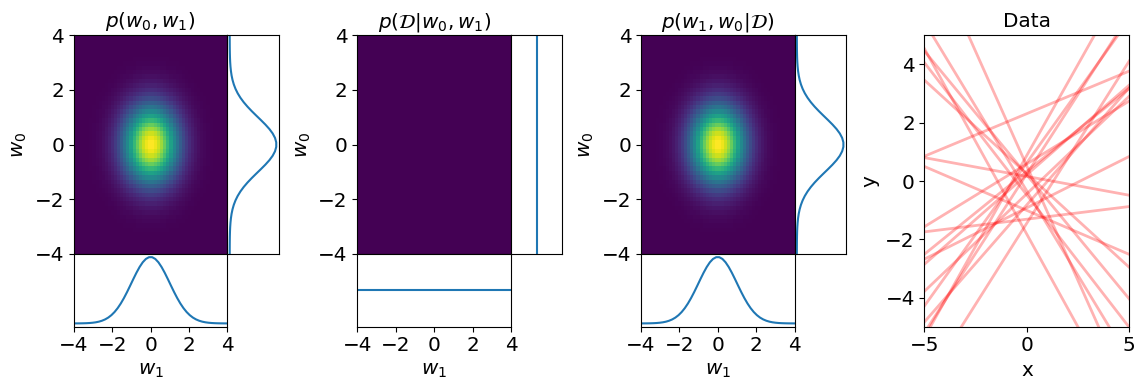

In [7]:
plot(I=0)

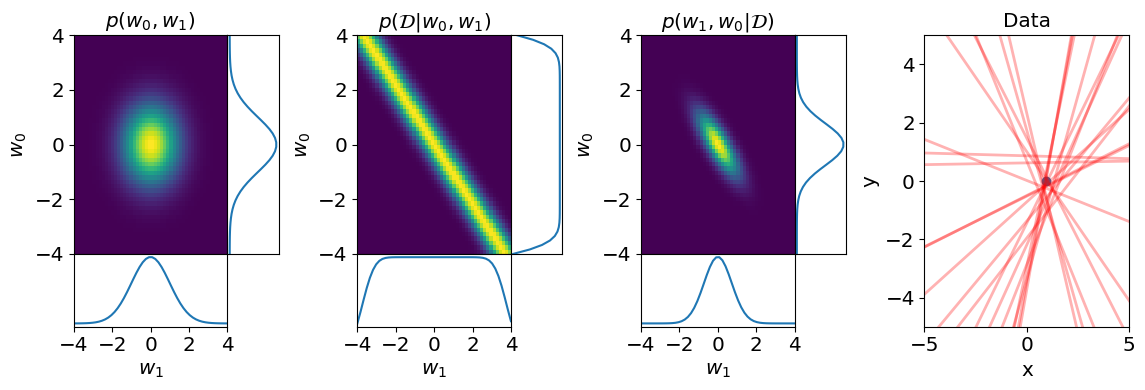

In [8]:
plot(I=1)

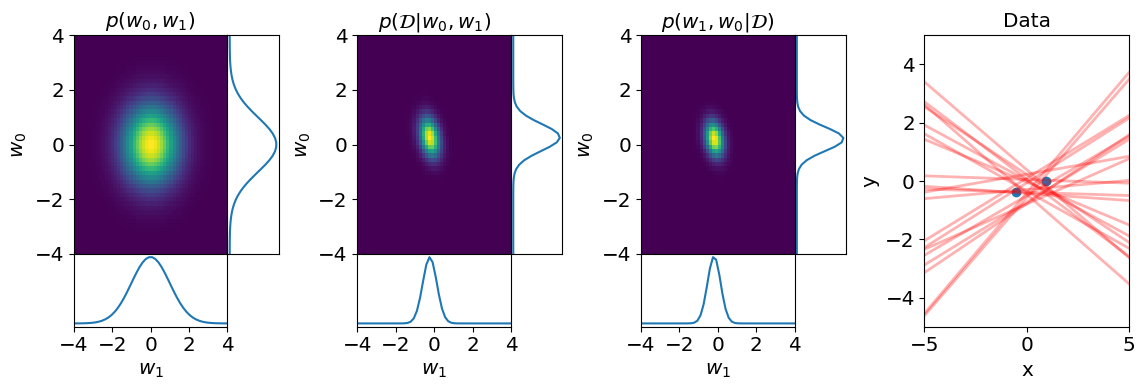

In [9]:
plot(I=2)

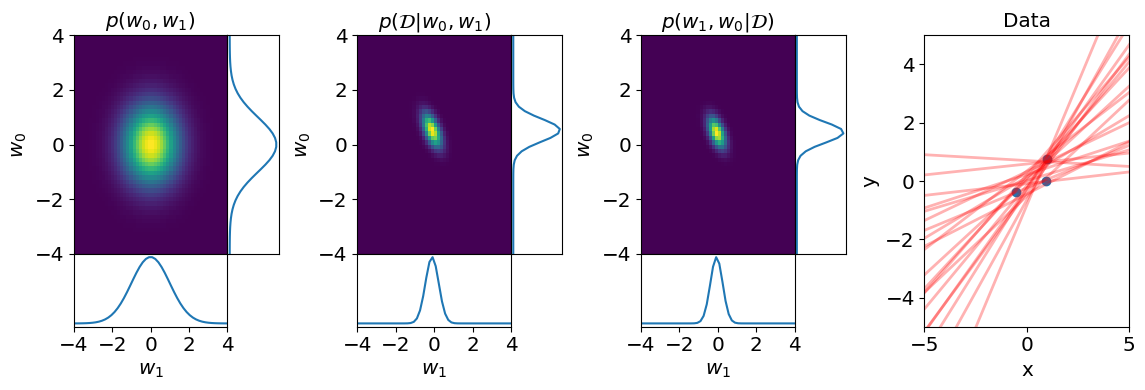

In [10]:
plot(I=3)

## Bayesian fits in practice

The plots shown previously look very nice, but in practice this is extremely slow: we are effectively trying all lines that may fit the points and excluding the ones that do not. We can do better than this in the simple case of a line fit.

Imagine we are trying to find the weights $w$ for a function $y = f(x) = w_M x_M + \ldots + w_2 x_2 + w_1 x_1 + w_0$. We assume that any mismatch between data and the prediction is caused by some random noise $\epsilon$ that is Gaussian and has standard deviation $1/\sqrt{\beta}$. In this case, we can assume that the probability that data $\mathcal{D}$ matches our prediction for a certain $x$ is given by the likelihood $p(\mathcal{D}|w) = \mathcal{N}(y=f(x), \frac{1}{\beta})$.

For a line fit, we can assume that the prior probability of the weights is given by $p(w) = \mathcal{N}(m_0, S_0)$ (ie: a Gaussian distribution, assuming we expect the weights to be close to $m_0$ and with some covariance $S_0$) and use the data likelihood $p(\mathcal{D}|w)$ to get the posterior probability $p(w|\mathcal{D})$.

One can use Bayes' theorem to obtain the posterior, which follows exactly a Gaussian distribution for the weights $w$ with mean $m$ and covariance $S$ given by:

$m = S \, (S_0^{-1} m_0 + \beta \, \Phi^T t)$,

$S = S_0^{-1} + \beta \, \Phi^T \Phi$.

This has been found by calculating the derivatives of the posterior distribution and setting it to zero to find its maximum.
In those equations, $t$ is a vector with the value of $y$ for each point in the dataset, and $\Phi$ (called the design matrix), includes the values of the vector $x$ for each point in the dataset.

$\Phi = \begin{pmatrix}
x_{M1} & \ldots & x_{21} & x_{11} \\
x_{M2} & \ldots & x_{22} & x_{12} \\
\vdots & \ddots & \vdots & \vdots \\
x_{MN} & \ldots & x_{2N} & x_{1N}
\end{pmatrix}
$

For more information, check Chapter 3 of C. Bishop's "Pattern Recognition and Machine Learning".

The issue with this method is that one needs to make a prior assumption about how strongly we believe the weights $w$ to be close to our prior assumption $m_0$. That is: what are $m_0$ and $S_0$? These are very important to regularize the fit, which prevents the fit from trying to fit only outliers.

To avoid this, hierarchical Bayesian fits are often used. In this case, we assume that $m_0$ is zero and $S_0$ depends of a result $\lambda$ of a different probability distribution. That is, if we imagine how data would be produce in a purely theoretical way, we have a cascade of probability distribution: we pick $\lambda$ from some distribution $p(\lambda)$, then we pick $w$ from $p(w|\lambda)$ and that allows us to produce data using $p(\mathcal{D}|w, \lambda)$.

Several textbooks are dedicated to this method and the choice of such distributions. One common example is the usage of a $\Gamma$ probability distribution for the variable $\lambda$. This is done in the `BayesianRidge` method implemented in scikit-learn. You can find more information on this here: 

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html#sklearn.linear_model.BayesianRidge

Let's try using this method to fit the data in the variable `data`:

In [11]:
from sklearn.linear_model import BayesianRidge
model = BayesianRidge()
model.fit(data[:,[0]], data[:,1])

BayesianRidge()

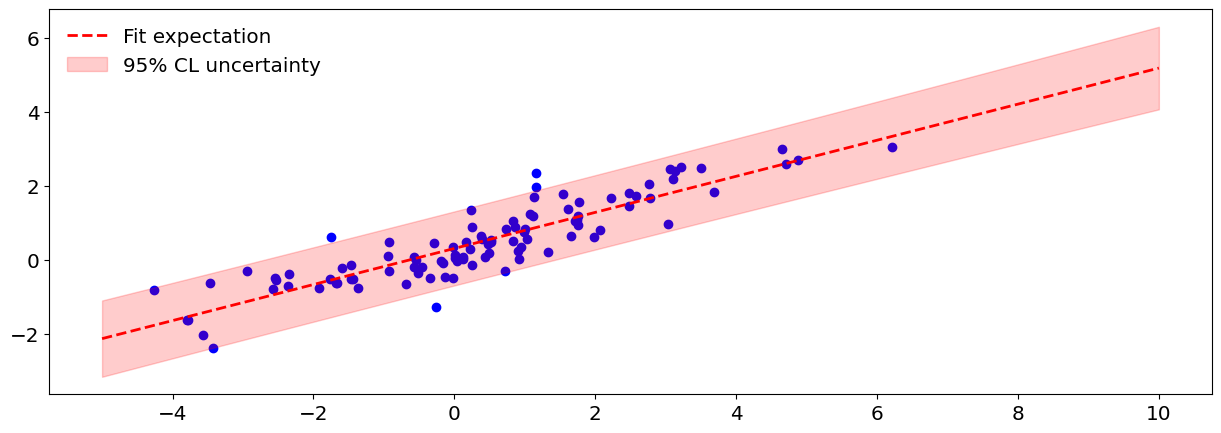

In [12]:
# let's create x values to predict y for
x_axis = np.linspace(-5, 10, 100)
# predict it
y_prediction, y_uncertainty = model.predict(x_axis[:, np.newaxis], return_std=True)

# now plot it:
plt.scatter(data[:,0], data[:,1], c='blue')
plt.plot(x_axis, y_prediction, c='red', lw=2, ls='--', label="Fit expectation")
plt.fill_between(x_axis, y_prediction + 2*y_uncertainty, y_prediction - 2*y_uncertainty, color="red", alpha=0.2, label="95% CL uncertainty")
plt.legend(frameon=False)

## Outliers

In the previous notebook, we discussed that outliers are a big problem there, since there is no regularization. Since the method above includes a prior probability on the weights that is Gaussian, this restricts the variation of the weights due to outliers. This is not perfect and the degree of regularization needs to be tuned in case of large outliers, but it is more resilient than the unregularized method.

Feel free to try adding outliers to the data and checking what happens to the parameters of the fit.

## Is this the only way?

There are *a lot* of other line fitting methods! They make different assumptions on the priors and likelihoods. We could make the assumption that $\epsilon$ follows a different distribution, changing the fit entirely: this is helpful to avoid sensitivity to outliers in some cases. Another change is that the priors could also follow a different distribuion. Using the Laplace distribution instead of the Gaussian often makes those parameters much more robust to outliers (this is called the *LASSO* estimator). Other line fitting methods could even assume that the prior probabilities depend on another probability distribution, called the *hyper-prior*, which then would also be included in Bayes' Theorem.

One example is called Automatic Relevance Determination, which is a variation of this method, using a slightly different setup for the probability distribution of $\lambda$. This other method has the advantage of being very resilient to noisy data in multi-dimensional cases and setting several weights $w$ to zero if they are smaller than the uncertainty.

More information on an implementation of ARD can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ARDRegression.html#sklearn.linear_model.ARDRegression

Why not try it in this simple example?